In [19]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)


In [9]:
import os
os.getcwd()

'/Users/sunzh81/Documents/GitHub/AnomalyDectection'

# Catfish Sales Data

In [10]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [11]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

In [12]:
# infer the frequency of the data, analyze the time differences between consecutive dates and try to determine the most appropriate frequency (e.g. monthly, daily, hourly)
# 'asfreq' is to resample the time series to the infeered frequency, if inferred = disired freq, do nothing; else, fill missing values to match the desired frequency
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

### Introduce an Anomaly

In [15]:
import datetime
idx = pd.IndexSlice

In [16]:
catfish_sales.loc["1998-12-1"]['Total'] = 10000

start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

In [15]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
...,...
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344


In [7]:
#At December 1 1998
lim_catfish_sales.iloc[0]

Total    20322
Name: 1996-01-01 00:00:00, dtype: int64

In [9]:
lim_catfish_sales

,Total
Date,
1996-01-01,20322
1996-02-01,20613
1996-03-01,22704
1996-04-01,20276
1996-05-01,20669
...,...
1999-09-01,24430
1999-10-01,25229
1999-11-01,22344


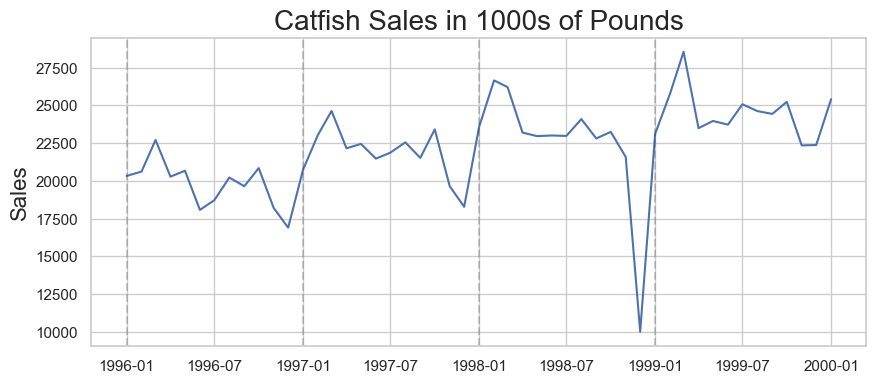

In [21]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Seasonal Decompose

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

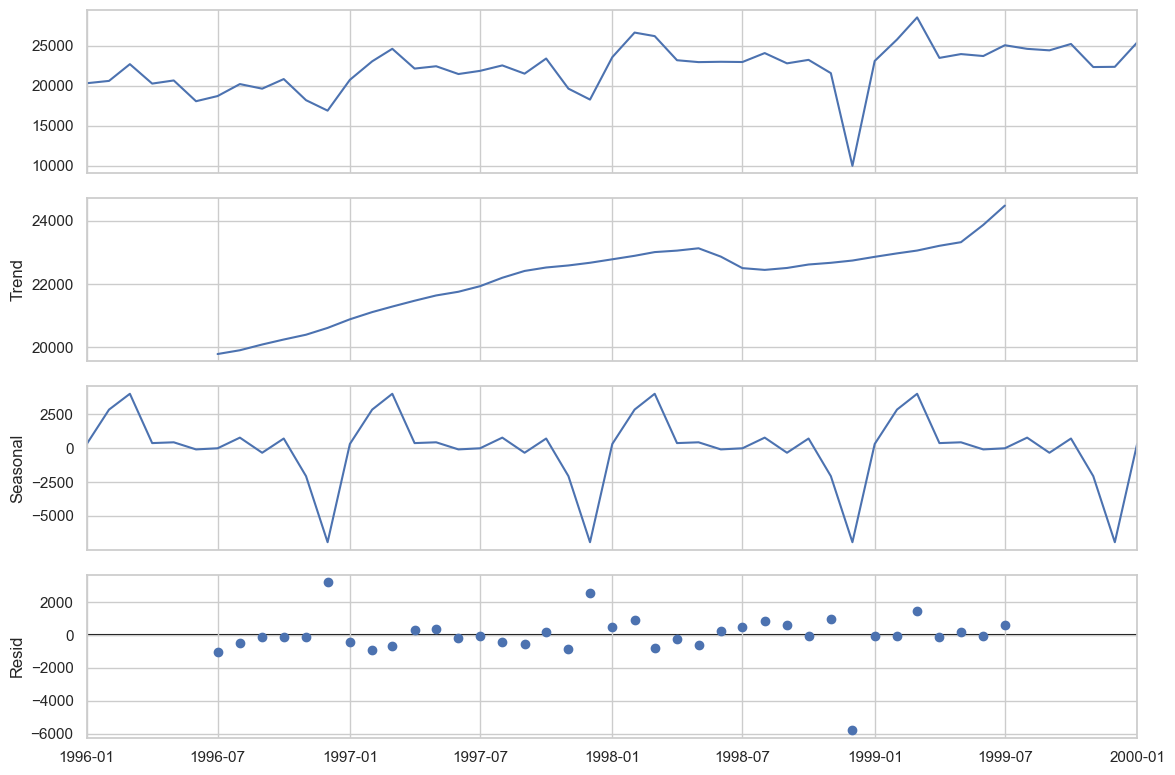

In [24]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(lim_catfish_sales,model='additive')
fig = result.plot()

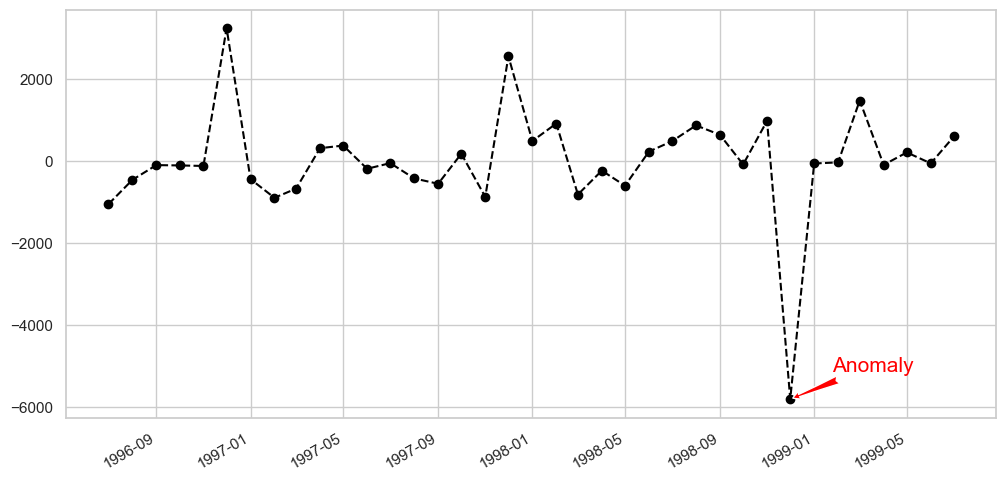

In [25]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')

ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20), 
           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))

fig.autofmt_xdate()
plt.show()

### Introduce some more point outliers

In [5]:
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

## Isolation forest

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<AxesSubplot:xlabel='Date'>

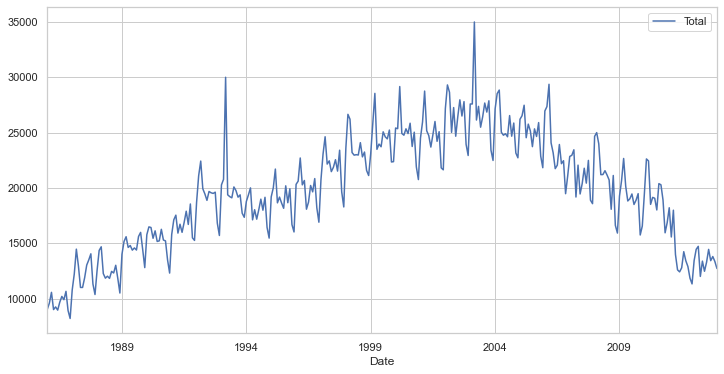

In [6]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

In [40]:
catfish_sales['anomaly'] 

Date
1986-01-01    1
1986-02-01    1
1986-03-01    1
1986-04-01    1
1986-05-01    1
             ..
2012-08-01    1
2012-09-01    1
2012-10-01    1
2012-11-01    1
2012-12-01    1
Freq: MS, Name: anomaly, Length: 324, dtype: int64

In [32]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [38]:
outliers_fraction = float(.01)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.01)

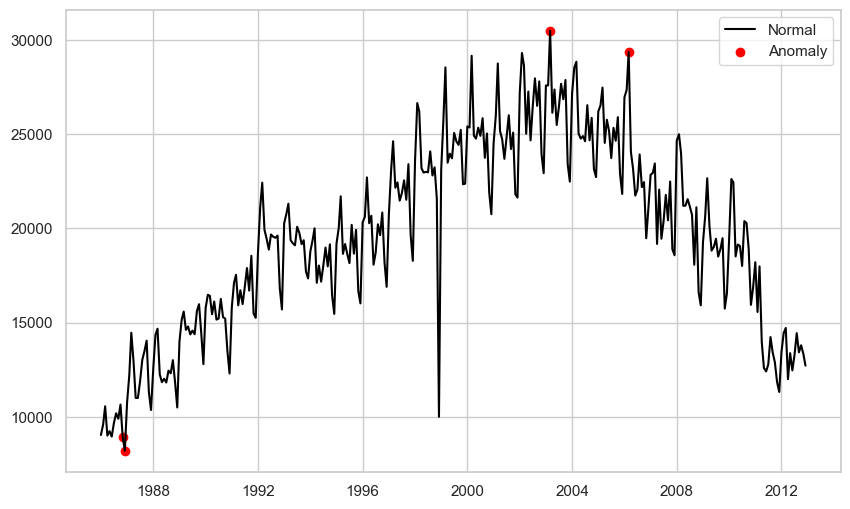

In [39]:
catfish_sales['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Kmeans

In [41]:
from sklearn.cluster import KMeans

In [42]:
df = pd.read_csv('TimeSeriesExpedia.csv')

In [43]:
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,63,2013-05-23 11:56:25,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,15,69.87,1,8192,4,25,3,0,1,0,NaN,1937.85,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,90,2013-04-23 11:12:24,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,6,97.49,1,8192,2,44,1,0,1,1,NaN,1208.63,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,133,2013-03-14 11:27:28,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,29,206.00,1,8192,3,99,1,0,1,1,NaN,397.74,1,NaN,NaN,NaN,-1.0,0.0,2.0,-1.0,0.0,2.0,NaN,NaN,NaN,-1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,148,2013-03-21 02:24:03,10,4,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,33,127.71,1,8192,4,227,1,0,1,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,203,2013-01-03 20:48:24,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,6,186.00,1,8192,3,6,2,0,1,0,NaN,222.13,0,NaN,NaN,NaN,1.0,0.0,14.0,0.0,0.0,20.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,14.0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,6290,2013-01-24 22:08:31,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,2,90.00,1,8192,1,1,4,1,2,1,NaN,212.58,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.0,0,NaN,0
50,6299,2013-05-20 10:25:55,14,100,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,31,131.82,1,8192,7,30,4,0,1,0,NaN,1036.40,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
51,6363,2012-12-27 11:21:45,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.29,22,46.00,1,8192,2,6,2,0,1,0,NaN,257.11,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
52,6551,2013-05-12 06:11:34,5,219,NaN,NaN,219,104517,4,4.0,1,4.16,0.2534,5.30,16,141.00,1,8192,2,145,1,0,1,1,NaN,1688.51,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


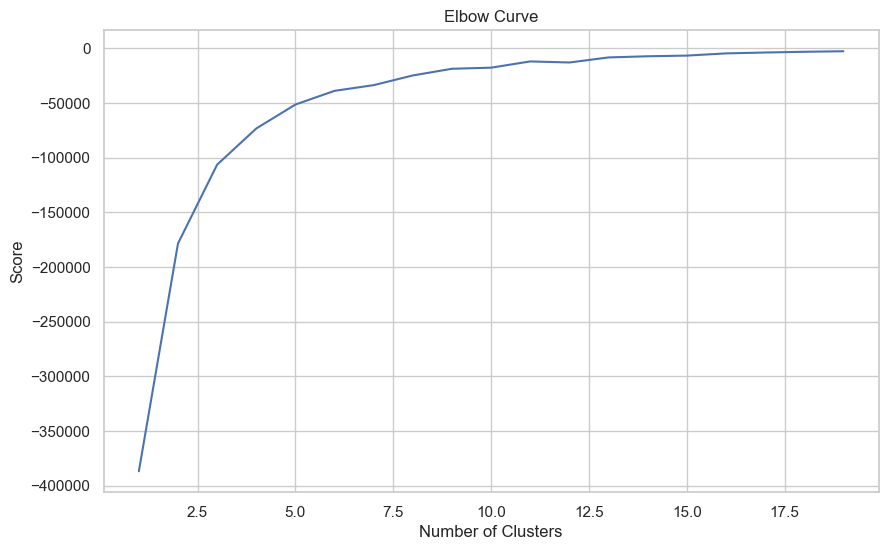

In [46]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

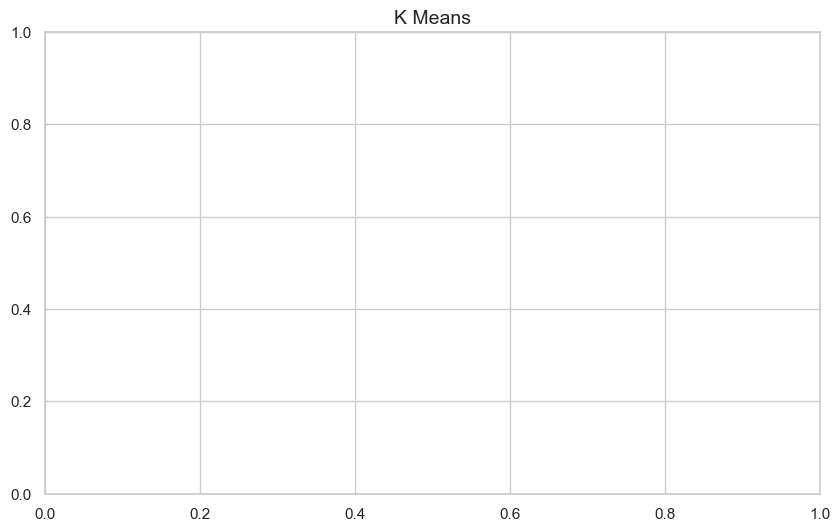

In [51]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
# #Plotting
fig,ax = plt.subplots(figsize=(10,6))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float64), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

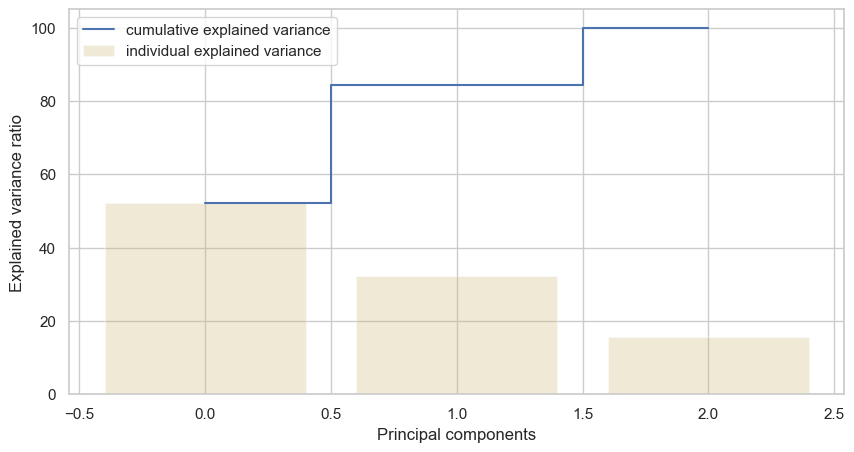

In [52]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'y')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [53]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [54]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

cluster
0    14
4    12
3     8
8     8
7     3
1     3
5     2
6     2
9     1
2     1
Name: count, dtype: int64

In [55]:
kmeans[9]

KMeans(n_clusters=10)

In [56]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

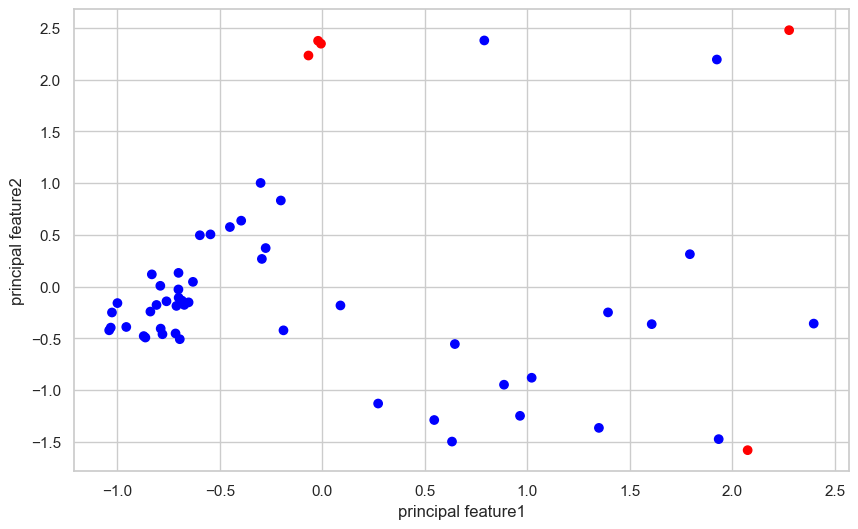

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

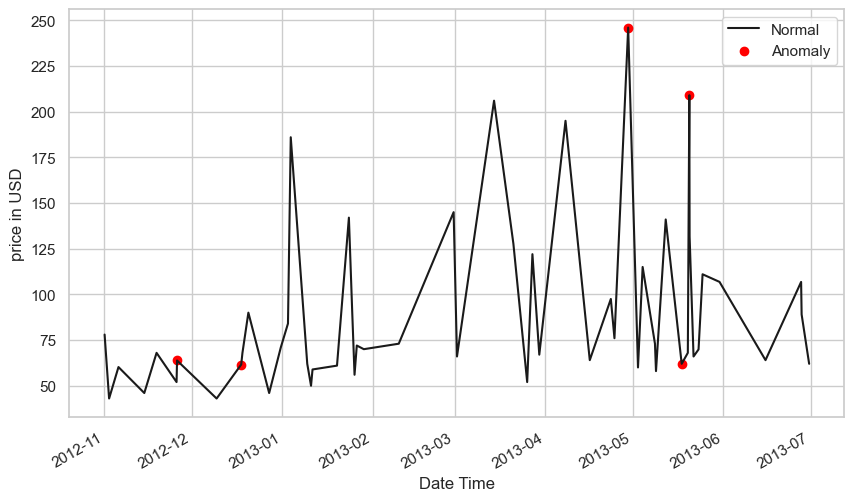

In [58]:
df = df.sort_values('date_time')
#df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly


ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()

## Forecasting

In [65]:
%pip  install fbprophet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 243.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.3 MB/s eta 0:00:00
  Using cached PyMeeus-0.5.12-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 4.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.5 MB/s eta 0:00:00a 0:00

In [62]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [26]:
t = pd.DataFrame()
t['ds'] = catfish_sales.index
t['y'] = catfish_sales['Total'].values

In [27]:
t

,ds,y
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239
...,...,...
319,2012-08-01,14442
320,2012-09-01,13422
321,2012-10-01,13795
322,2012-11-01,13352


In [29]:
import altair as alt
#alt.renderers.enable('notebook')

In [28]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(t)

In [31]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [33]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

# Autoencoders

In [66]:
%pip install pyod

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 437.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 2.1 MB/s eta 0:00:0000:0100:01
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190289 sha256=9b2cf5c94fb7b8db9dfe87de3070c5ae68dabb34e1a906a3b6e993dd456a72e3
  Stored in directory: /Users/sunzh81/Library/Caches/pip/wheels/50/9a/0a/3dbfe8f4cbe48d9cfcb6c9cdb5cf077cb942888bd8ecb8cd74
Successfully built pyod
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [3]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

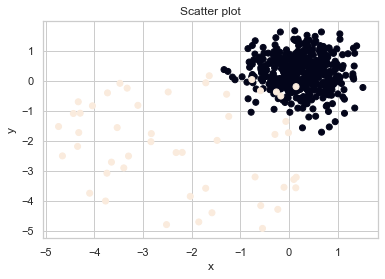

In [4]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'red', 1: 'blue'}
# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=1)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                650       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f895a94c400>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

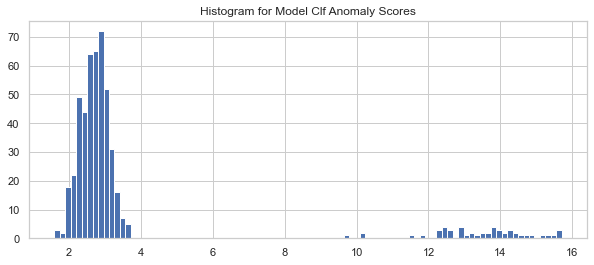

In [6]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf Anomaly Scores")
plt.show()

In [7]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

t = df_test.groupby('cluster').mean()

In [9]:
pd.set_option('display.max_rows', 500)
t.T

cluster,0,1
0,0.248812,-2.239305
1,0.235591,-2.120321
2,0.254013,-2.286113
3,0.239429,-2.154863
4,0.239101,-2.151912
5,0.255499,-2.299489
6,0.257207,-2.314860
7,0.244380,-2.199420
8,0.248004,-2.232040
9,0.251948,-2.267535


# What to do about the anomaly?

## Simple Idea: use mean of other months

In [29]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

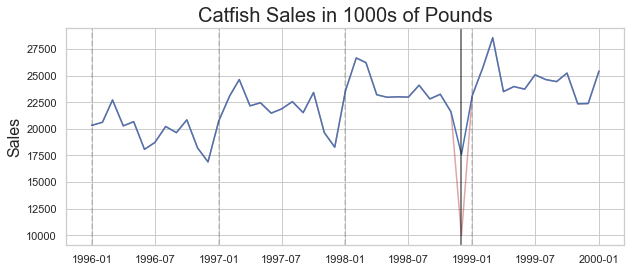

In [30]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

# Resulting Predictions

In [31]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [32]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [33]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

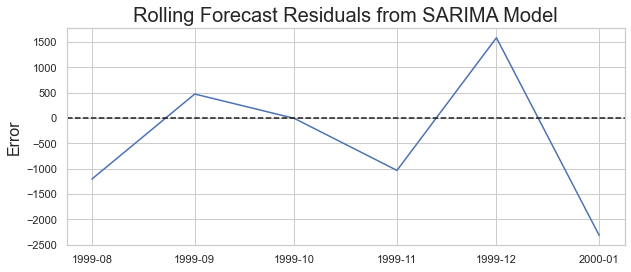

In [34]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

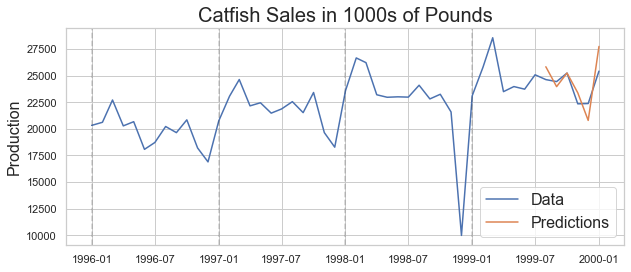

In [35]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [36]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0461


In [37]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1329.8806978276243
